In [1]:
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from autogluon.tabular import TabularPredictor, TabularDataset


c:\Users\s24331\Desktop\PUM_01\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
customers = pd.read_csv("data/customers_labeled.csv")
customers

customerID gender  age_first_order user_agent_brand user_agent_os  \
0         000018      F             59.0           Chrome       Windows   
1         000071      F             48.0           Chrome       MacOS X   
2         000440      M             44.0           Chrome       Windows   
3         000452      M             62.0           Chrome       Windows   
4         000652      M             20.0          Firefox       Windows   
...          ...    ...              ...              ...           ...   
10782     zxvu44      F              NaN          Firefox       Windows   
10783     zyvn97      F             47.0           Chrome       Windows   
10784     zzolm4      M             62.0           Chrome       Windows   
10785     zzw4gs      F             61.0           Chrome       Windows   
10786     zzwlin      F             52.0           Chrome       Windows   

           ip_address_geopoint ip_address_country  campaign  \
0       POINT(21.0362 52.2394)             Poland     False   
1      POINT(139.6895 35.6897)              Japan      True   
2                  POINT(-2 8)              Ghana      True   
3      POINT(139.6895 35.6897)              Japan     False   
4        POINT(-97.822 37.751)      United States     False   
...                        ...                ...       ...   
10782   POINT(31.2852 30.0778)              Egypt     False   
10783    POINT(-97.822 37.751)      United States     False   
10784    POINT(-97.822 37.751)      United States     False   
10785    POINT(-97.822 37.751)      United States     False   
10786  POINT(-80.0671 42.0753)      United States     False   

       pages_visited_avg  high_revenue  
0              12.000000         False  
1              12.666667         False  
2              14.200000          True  
3              15.000000         False  
4              10.000000         False  
...                  ...           ...  
10782           9.000000         False  
10783          14.500000         False  
10784          14.000000         False  
10785          12.000000         False  
10786           6.000000         False  

[10787 rows x 10 columns]

In [3]:
label = "high_revenue"

In [4]:
X = customers.drop([label], axis=1)
y = customers[label]
X_res, y_res = RandomUnderSampler(random_state=42).fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

In [5]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [6]:
td_train = TabularDataset(train)

In [7]:
predictor = TabularPredictor(label=label, eval_metric="accuracy").fit(
    train_data=td_train,
    time_limit=60,
    presets="best_quality",
    hyperparameters={
    "GBM": {"extra_trees": True, "ag_args": {"name_suffix": "GBM"}},
    "CAT": {"ag_args": {"name_suffix": "CAT"}},
    "XGB": {"ag_args": {"name_suffix": "XGB"}},
    "RF": {"ag_args": {"name_suffix": "RF"}},
    "NN_TORCH": {"ag_args": {"name_suffix": "NN_TORCH"}}}


)

No path specified. Models will be saved in: "AutogluonModels\ag-20250513_132551"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       5.48 GB / 15.69 GB (34.9%)
Disk Space Avail:   197.73 GB / 471.56 GB (41.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

In [8]:
td_test= TabularDataset(test)

In [9]:
y_pred = predictor.predict(td_test.drop(columns=[label]), as_pandas=True)
y_pred 

10562    False
5385     False
9366     False
7300      True
500      False
         ...  
3196     False
1356      True
6295     False
3625      True
2964     False
Name: high_revenue, Length: 398, dtype: bool

In [10]:
y_pred_proba = predictor.predict_proba(td_test, as_pandas=True)
y_pred_proba

False     True 
10562  0.512363  0.487637
5385   0.706862  0.293138
9366   0.638673  0.361327
7300   0.440418  0.559582
500    0.563272  0.436728
...         ...       ...
3196   0.665065  0.334935
1356   0.346932  0.653068
6295   0.510179  0.489821
3625   0.392321  0.607679
2964   0.525326  0.474674

[398 rows x 2 columns]

In [11]:
predictor.leaderboard(td_test, silent=True)

model  score_test  score_val eval_metric  pred_time_test  \
0     LightGBMGBM_BAG_L1    0.708543   0.740554    accuracy        0.070425   
1    WeightedEnsemble_L3    0.708543   0.751259    accuracy        0.281349   
2     LightGBMGBM_BAG_L2    0.708543   0.751259    accuracy        0.281349   
3     CatBoostCAT_BAG_L1    0.698492   0.748111    accuracy        0.029932   
4    WeightedEnsemble_L2    0.698492   0.748111    accuracy        0.040022   
5  RandomForestRF_BAG_L2    0.698492   0.743703    accuracy        0.380125   
6  RandomForestRF_BAG_L1    0.693467   0.706549    accuracy        0.130769   

   pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0       0.056450   1.218962                 0.070425                0.056450   
1       0.293910  15.101647                 0.000000                0.000000   
2       0.293910  15.051313                 0.050224                0.035807   
3       0.035540  11.805167                 0.029932                0.035540   
4       0.036537  11.847250                 0.010089                0.000997   
5       0.460397  14.794094                 0.148999                0.202294   
6       0.166113   0.953273                 0.130769                0.166113   

   fit_time_marginal  stack_level  can_infer  fit_order  
0           1.218962            1       True          1  
1           0.050334            3       True          7  
2           1.073911            2       True          5  
3          11.805167            1       True          3  
4           0.042083            2       True          4  
5           0.816692            2       True          6  
6           0.953273            1       True          2

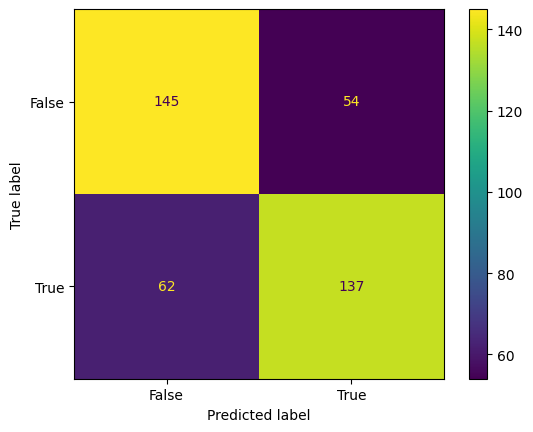

In [12]:
cm = confusion_matrix(td_test[label], y_pred)
ConfusionMatrixDisplay(cm, display_labels=predictor.classes_).plot()